In [10]:
import pandas as pd

# 要为该数据集自定义列名
iris_data = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data', names = ['sepal_length_cm', 'sepal_width_cm', 'petal_length_cm', 'petal_width_cm', 'class'])

In [11]:
iris_data.head()

,sepal_length_cm,sepal_width_cm,petal_length_cm,petal_width_cm,class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [12]:
# 数据集统计摘要
iris_data.describe()

,sepal_length_cm,sepal_width_cm,petal_length_cm,petal_width_cm
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.054000,3.758667,1.198667
std,0.828066,0.433594,1.764420,0.763161
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


In [13]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns

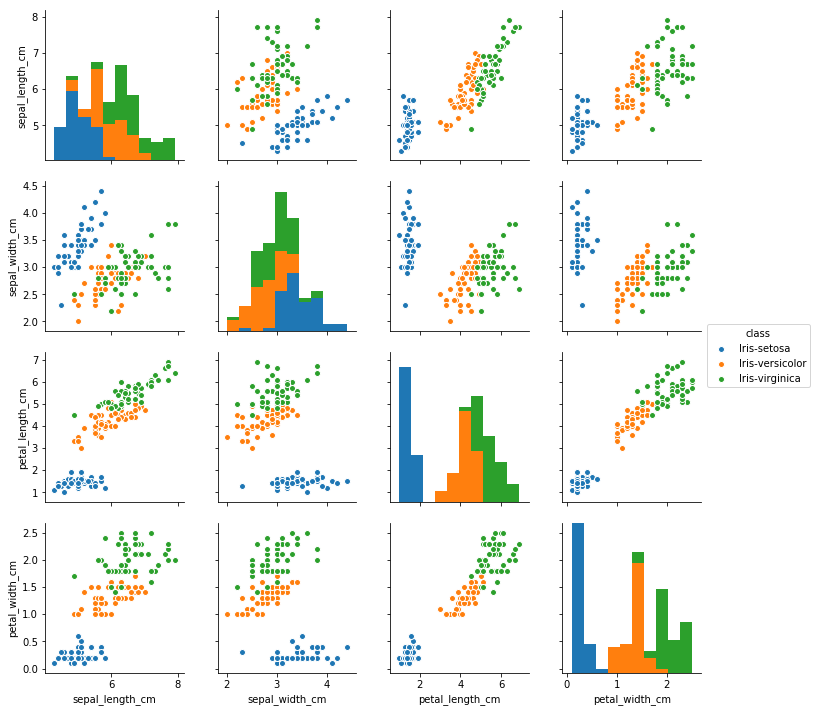

In [14]:
sns.pairplot(iris_data.dropna(), hue='class')

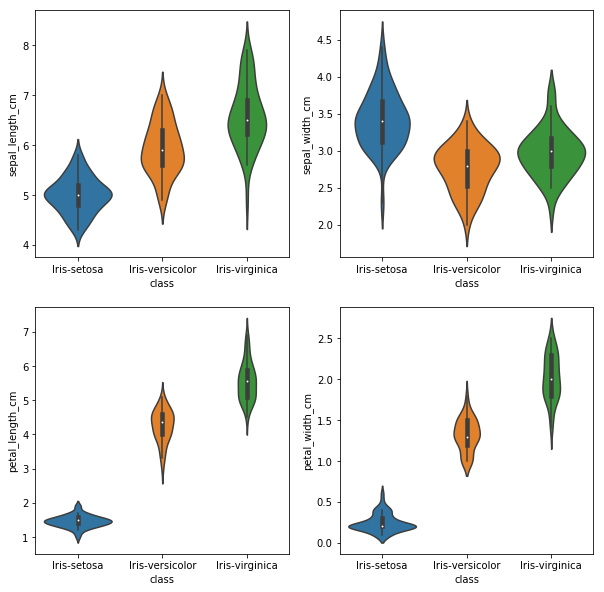

In [15]:
# 绘制 violin plots
plt.figure(figsize=(10, 10))

for column_index, column in enumerate(iris_data.columns):
    if column == 'class':
        continue
    plt.subplot(2, 2, column_index + 1)
    sns.violinplot(x='class', y=column, data=iris_data)

In [16]:
# 提取数据
all_inputs = iris_data[['sepal_length_cm', 'sepal_width_cm', 'petal_length_cm', 'petal_width_cm']].values
# 提取 class
all_classes = iris_data['class'].values

In [17]:
all_inputs[:5]

array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2],
       [4.7, 3.2, 1.3, 0.2],
       [4.6, 3.1, 1.5, 0.2],
       [5. , 3.6, 1.4, 0.2]])

In [27]:
# 划分训练集和测试集
from sklearn.cross_validation import train_test_split

(training_inputs, 
 testing_inputs, 
 training_classes, 
 testing_classes) = train_test_split(all_inputs, all_classes, train_size=0.75, random_state=1)

In [28]:
# 使用决策树去训练模型
from sklearn.tree import DecisionTreeClassifier

# 建立分类器
decision_tree_classifier = DecisionTreeClassifier()

# 用训练集去训练分类器
decision_tree_classifier.fit(training_inputs, training_classes)

# 用测试集去检验训练好的分类器
decision_tree_classifier.score(testing_inputs, testing_classes)

0.9736842105263158

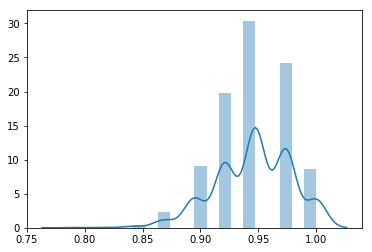

In [30]:
# 查看根据训练集和测试集的采样，分类正确率的变化
model_accuracies = []

for repetition in range(1000):
    (training_inputs,
     testing_inputs,
     training_classes,
     testing_classes) = train_test_split(all_inputs, all_classes, train_size=0.75)
    
    decision_tree_classifier = DecisionTreeClassifier()
    decision_tree_classifier.fit(training_inputs, training_classes)
    classifier_accuracy = decision_tree_classifier.score(testing_inputs, testing_classes)
    model_accuracies.append(classifier_accuracy)
    
sns.distplot(model_accuracies)

有过拟合的趋势，进行交叉检验

将原始数据集划分为k个子集，用其中一个子集作为测试集

剩下的所有子集用作训练集。这个过程将重复k次，每一个子集都有一次机会作为测试集

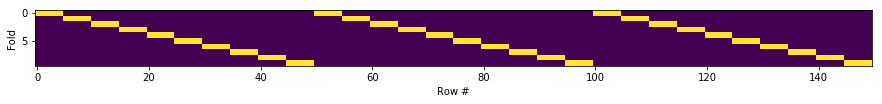

In [34]:
# 10-fold cross-validation 原理说明
import numpy as np
from sklearn.cross_validation import StratifiedKFold

def plot_cv(cv, n_samples):
    masks = []
    for train, test in cv:
        mask = np.zeros(n_samples, dtype=bool)
        mask[test] = 1
        masks.append(mask)
        
    plt.figure(figsize=(15, 15))
    plt.imshow(masks, interpolation='none')
    plt.ylabel('Fold')
    plt.xlabel('Row #')
    
plot_cv(StratifiedKFold(all_classes, n_folds=10), len(all_classes))

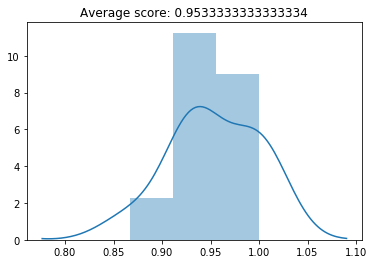

In [36]:
from sklearn.cross_validation import cross_val_score

decision_tree_classifier = DecisionTreeClassifier()

# cross_val_score(cv_scores)返回了一个list，我们可以对它进行可视化，来查看分类器的表现
cv_scores = cross_val_score(decision_tree_classifier, all_inputs, all_classes, cv=10)
sns.distplot(cv_scores)
plt.title('Average score: {}'.format(np.mean(cv_scores)))
plt.show()

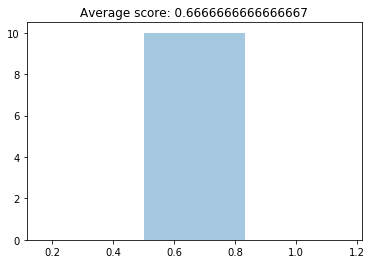

In [38]:
# 调整超参数 max_depth，可以看到准确率下降严重
decision_tree_classifier = DecisionTreeClassifier(max_depth=1)

cv_scores = cross_val_score(decision_tree_classifier, all_inputs, all_classes, cv=10)
sns.distplot(cv_scores, kde=False)
plt.title('Average score: {}'.format(np.mean(cv_scores)))
plt.show()

In [64]:
# 探索 max_depth 和 max_features 进行调参
from sklearn.grid_search import GridSearchCV

decision_tree_classifier = DecisionTreeClassifier()

parameter_grid = {'max_depth': [1, 2, 3, 4, 5],
                  'max_features': [1, 2, 3, 4]}

cross_validation = StratifiedKFold(all_classes, n_folds=10)

grid_search = GridSearchCV(decision_tree_classifier,
                           param_grid=parameter_grid,
                           cv=cross_validation)

grid_search.fit(all_inputs, all_classes)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

Best score: 0.96
Best parameters: {'max_depth': 3, 'max_features': 4}


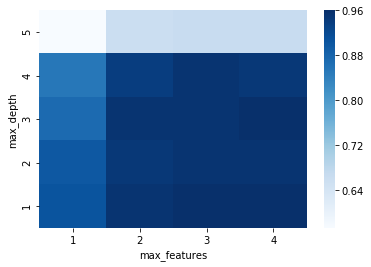

In [65]:
# 可视化调参过程

grid_visualization = []

for grid_pair in grid_search.grid_scores_:
    grid_visualization.append(grid_pair.mean_validation_score)
    
grid_visualization = np.array(grid_visualization)
grid_visualization.shape = (5, 4)
sns.heatmap(grid_visualization, cmap='Blues')
plt.xticks(np.arange(4) + 0.5, grid_search.param_grid['max_features'])
plt.yticks(np.arange(5) + 0.5, grid_search.param_grid['max_depth'][::-1])
plt.xlabel('max_features')
plt.ylabel('max_depth')
plt.show()

In [66]:
# 尝试调整更多的参数

decision_tree_classifier = DecisionTreeClassifier()

parameter_grid = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': [1, 2, 3, 4, 5],
    'max_features': [1, 2, 3, 4]
}

cross_validation = StratifiedKFold(all_classes, n_folds=10)

grid_search = GridSearchCV(decision_tree_classifier,
                          param_grid=parameter_grid,
                          cv=cross_validation)

grid_search.fit(all_inputs, all_classes)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

Best score: 0.9666666666666667
Best parameters: {'criterion': 'entropy', 'max_depth': 4, 'max_features': 3, 'splitter': 'best'}


In [67]:
decision_tree_classifier = grid_search.best_estimator_
decision_tree_classifier

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=4,
            max_features=3, max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

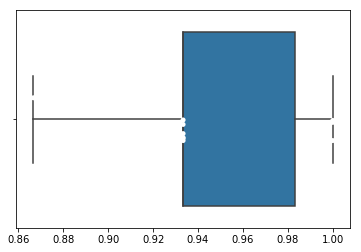

In [68]:
dt_scores = cross_val_score(decision_tree_classifier, all_inputs, all_classes, cv=10)

sns.boxplot(dt_scores)
sns.stripplot(dt_scores, jitter=True, color='white')

In [69]:
# 引入一个新的分类器随机森林，和之前的决策数做对比

from sklearn.ensemble import RandomForestClassifier

random_forest_classifier = RandomForestClassifier()

parameter_grid = {
    'n_estimators': [5, 10, 25, 50],
    'criterion': ['gini', 'entropy'],
    'max_features': [1, 2, 3, 4],
    'warm_start': [True, False]
}

cross_validation = StratifiedKFold(all_classes, n_folds=10)

grid_search = GridSearchCV(random_forest_classifier,
                           param_grid=parameter_grid,
                           cv=cross_validation)

grid_search.fit(all_inputs, all_classes)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

grid_search.best_estimator_

Best score: 0.9666666666666667
Best parameters: {'criterion': 'gini', 'max_features': 1, 'n_estimators': 50, 'warm_start': True}


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=1, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=False, random_state=None, verbose=0, warm_start=True)

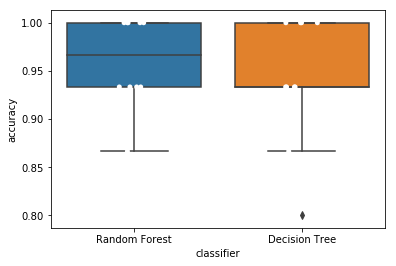

In [70]:
# 比较两个分类器的表现
random_forest_classifier = grid_search.best_estimator_

rf_df = pd.DataFrame({
    'accuracy': cross_val_score(random_forest_classifier, all_inputs, all_classes, cv=10),
    'classifier': ['Random Forest'] * 10
})

dt_df = pd.DataFrame({
    'accuracy': cross_val_score(decision_tree_classifier, all_inputs, all_classes, cv=10),
    'classifier': ['Decision Tree'] * 10
})
both_df = rf_df.append(dt_df)

sns.boxplot(x='classifier', y='accuracy', data=both_df)
sns.stripplot(x='classifier', y='accuracy', data=both_df, jitter=True, color='white')
plt.show()

两个分类器在这个数据集上表现比较相似。随机森林模型在数据集有多个特征时表现更好。

### 过程复用

[6.4 3.1 5.5 1.8]	-->	Iris-virginica	(Actual: Iris-virginica)
[4.9 2.5 4.5 1.7]	-->	Iris-versicolor	(Actual: Iris-virginica)
[6.2 2.9 4.3 1.3]	-->	Iris-versicolor	(Actual: Iris-versicolor)
[6.3 2.3 4.4 1.3]	-->	Iris-versicolor	(Actual: Iris-versicolor)
[5.1 3.5 1.4 0.3]	-->	Iris-setosa	(Actual: Iris-setosa)
[5.  3.2 1.2 0.2]	-->	Iris-setosa	(Actual: Iris-setosa)
[5.8 2.7 4.1 1. ]	-->	Iris-versicolor	(Actual: Iris-versicolor)
[7.4 2.8 6.1 1.9]	-->	Iris-virginica	(Actual: Iris-virginica)
[7.2 3.2 6.  1.8]	-->	Iris-virginica	(Actual: Iris-virginica)
[7.1 3.  5.9 2.1]	-->	Iris-virginica	(Actual: Iris-virginica)


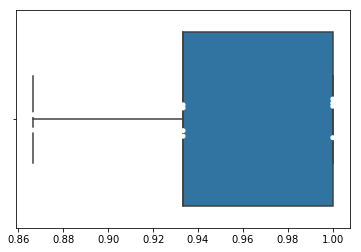

In [72]:
# 将之前的步骤整理成一个可以复刻的 pipeline

%matplotlib inline
import pandas as pd
import seaborn as sb
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import train_test_split, cross_val_score

iris_data = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data', names = ['sepal_length_cm', 'sepal_width_cm', 'petal_length_cm', 'petal_width_cm', 'class'])

# input
all_inputs = iris_data[['sepal_length_cm', 'sepal_width_cm',
                             'petal_length_cm', 'petal_width_cm']].values
all_classes = iris_data['class'].values

# 分类器 & Grid Search
random_forest_classifier = RandomForestClassifier(bootstrap=True, class_weight=None,
                                                 criterion='gini', max_depth=None,
                                                 max_features=3, max_leaf_nodes=None,
                                                 min_samples_leaf=1, min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0, n_estimators=5,
                                                 n_jobs=1, oob_score=False,
                                                 random_state=None, verbose=0,
                                                 warm_start=True)

# cross-validation scores
rf_classifier_scores = cross_val_score(random_forest_classifier, all_inputs, all_classes, cv=10)
sb.boxplot(rf_classifier_scores)
sb.stripplot(rf_classifier_scores, jitter=True, color='white')

# 展示其中分类器预测结果的一部分
(training_inputs,
 testing_inputs,
 training_classes,
 testing_classes) = train_test_split(all_inputs, all_classes, train_size=0.75)

random_forest_classifier.fit(training_inputs, training_classes)

for input_features, prediction, actual in zip(testing_inputs[:10],
                                              random_forest_classifier.predict(testing_inputs[:10]),
                                              testing_classes[:10]):
    print('{}\t-->\t{}\t(Actual: {})'.format(input_features, prediction, actual))